<a href="https://colab.research.google.com/github/paveethranswam/Speech-style-transfer-and-ASR/blob/main/final_Deep_Speech_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Reference: https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch/
# https://keras.io/examples/audio/ctc_asr/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [5]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f00aff75-0f32-32c8-1522-f801c2f5fdac)


In [6]:
# Set torch random seed 
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [7]:
!pip install torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import os

import IPython
import requests
import torchaudio
from IPython.display import Audio, display
from torch._C import parse_schema

In [ ]:
!unzip "/content/drive/My Drive/DLS_Project/Dataset/DR-VCTK/DR-VCTK.zip" -d "./DR-VCTK"

In [10]:
DR_VCTK_DATASET_PATH = "./DR-VCTK/"

In [11]:
os.makedirs(DR_VCTK_DATASET_PATH, exist_ok=True)
print(DR_VCTK_DATASET_PATH)

./DR-VCTK/


In [12]:
# Getting precomputed transcript mapping
import pickle
from google.colab import files

with open('./final_w2v_transcript_dictionary2.pkl', 'rb') as f:
    speaker_utterance_final = pickle.load(f)

In [13]:
drvctk_train_dataset = torchaudio.datasets.DR_VCTK(DR_VCTK_DATASET_PATH, subset='train',download=False)

In [14]:
drvctk_test_dataset = torchaudio.datasets.DR_VCTK(DR_VCTK_DATASET_PATH, subset='test',download=False)

In [15]:
print(len(drvctk_train_dataset))
print(len(drvctk_test_dataset))

11572
824


In [16]:
from torch import nn

In [17]:
!pip install jiwer
from jiwer import wer
from jiwer import cer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 38.8 MB/s 
     |████████████████████████████████| 2.2 MB 66.6 MB/s 


In [18]:
char_map = {"'": 0, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, ' ': 1}

In [19]:
reverse_char_map = {0: "'", 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 1: ' '}

In [20]:
def label_to_index(text):
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map[' ']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

def index_to_label(labels):
    string = []
    for i in labels:
        string.append(reverse_char_map[i])
    return ''.join(string)

In [21]:
# Transforms on input spectrograms

train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [22]:

def processing_collate_fn(data, type1="train", type2 = "clean"):

    # returns
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []

    for (clean_waveform, _, noisy_waveform, _, speaker_id, utterance_id, _, _) in data:
        if type1 == 'train':
          if type2 == 'clean':
            spec = train_audio_transforms(clean_waveform).squeeze(0).transpose(0, 1)
          else:
            spec = train_audio_transforms(noisy_waveform).squeeze(0).transpose(0, 1)
        else:
          if type2 == 'clean':
            spec = valid_audio_transforms(clean_waveform).squeeze(0).transpose(0, 1)
          else:
            spec = valid_audio_transforms(noisy_waveform).squeeze(0).transpose(0, 1)

        spectrograms.append(spec)

        sample_utterance = speaker_utterance_final[speaker_id][utterance_id]

        sample_utterance = sample_utterance.lower()


        res = []
        for c_i in range(len(sample_utterance)):

          if sample_utterance[c_i] == "|":
            res.append(" ") 
          else:
            res.append(sample_utterance[c_i])
        sample_utterance = "".join(res)

        sample_utterance = sample_utterance.rstrip()

        good = set(char_map.keys())
        if set(sample_utterance) <= good:
            pass
        else:
            print(sample_utterance)
            print("Issue with Label")

  
        label = torch.Tensor(label_to_index(sample_utterance))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

In [23]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 

class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)
        
class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

In [24]:
# Set Hyperparameters
n_epochs = 10 # max_epochs
batch_size_train = 15 # batch size train set
batch_size_test = 15 # batch size test set
learning_rate = 5e-4 # learn rate
log_interval = 1 # log every _ epoch


n_cnn_layers = 3
n_rnn_layers = 3
rnn_dim = 512
n_class = 29
n_feats = 128
stride = 2
dropout = .1

In [25]:
model = SpeechRecognitionModel(n_cnn_layers, n_rnn_layers, rnn_dim,n_class, n_feats, stride, dropout).to(device)

In [26]:
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2) # arg max n classes
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes): # for sample in batch
        decode = []
        targets.append(index_to_label(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args): # for frame in sample
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(index_to_label(decode))
    return decodes, targets

In [27]:
!pip install jiwer
from jiwer import wer
from jiwer import cer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import numpy as np

# Results of Training
clean_train_losses = []
noisy_train_losses = []
wers_epoch = []
cers_epoch = []


Training_Result = (clean_train_losses, noisy_train_losses, wers_epoch, cers_epoch)

In [29]:
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_clean_loader = torch.utils.data.DataLoader(dataset=drvctk_train_dataset,
                                batch_size=batch_size_train,
                                shuffle=True,
                                collate_fn=lambda x: processing_collate_fn(x, type1="train", type2 = "clean"),
                                **kwargs)
test_clean_loader = torch.utils.data.DataLoader(dataset=drvctk_test_dataset,
                            batch_size=batch_size_train,
                            shuffle=False,
                            collate_fn=lambda x: processing_collate_fn(x, type1="valid", type2 = "clean"),
                            **kwargs)

train_noisy_loader = torch.utils.data.DataLoader(dataset=drvctk_train_dataset,
                            batch_size=batch_size_train,
                            shuffle=True,
                            collate_fn=lambda x: processing_collate_fn(x, type1="train", type2 = "noisy"),
                            **kwargs)
test_noisy_loader = torch.utils.data.DataLoader(dataset=drvctk_test_dataset,
                            batch_size=batch_size_train,
                            shuffle=False,
                            collate_fn=lambda x: processing_collate_fn(x, type1="valid", type2 = "noisy"),
                            **kwargs)



In [30]:
optimizer = optim.AdamW(model.parameters(), learning_rate)
criterion = nn.CTCLoss(blank=28, zero_infinity=True).to(device)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                                        steps_per_epoch=int(len(train_clean_loader)),
                                        epochs=20,
                                        anneal_strategy='linear')

In [31]:
import math

In [32]:
import copy

# Train Function
def train(Training_Result_p):

  clean_train_losses, noisy_train_losses, wers_epoch, cers_epoch = Training_Result_p

  # Train parameters
  epoch = 1 # starting epoch

  data_len = len(drvctk_train_dataset)
 
  print("Training model")

  torch.autograd.set_detect_anomaly(True)

  while ((epoch <= n_epochs) ):
    print("Epoch :{}".format(epoch))
    print()
    
    # Training
    model.train()
    train_loss = [] # calc train loss
    for batch_idx, _data in enumerate(train_clean_loader):

      spectrograms, labels, input_lengths, label_lengths = _data 

      spectrograms, labels = spectrograms.to(device), labels.to(device)

      optimizer.zero_grad()

      output = model(spectrograms)  # (batch, time, n_class)
      output = F.log_softmax(output, dim=2)
      output = output.transpose(0, 1) # (time, batch, n_class)

      drop = False
      for label_sequence in range(len(label_lengths)):
          if label_lengths[label_sequence] > 512 or label_lengths[label_sequence]+1 >= input_lengths[label_sequence]:
            drop = True

      if (drop):
        continue

      loss = criterion(output, labels, input_lengths, label_lengths)

      
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      if (not math.isnan(loss.item())) and (loss.item() != float("inf")):
          train_loss.append(loss.item())
      if batch_idx % 100 == 0 or batch_idx == data_len:
          print('++++++++Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}++++++++++++++++'.format(
              epoch, batch_idx * len(spectrograms), data_len,
              100. * batch_idx / len(train_clean_loader), loss.item()))

      optimizer.step()
      scheduler.step()
    
    clean_train_losses.append(train_loss / len(drvctk_train_dataset))

    # Evaluation 
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
      for batch_idx, _data in enumerate(test_clean_loader):

        spectrograms, labels, input_lengths, label_lengths = _data 

        spectrograms, labels = spectrograms.to(device), labels.to(device)

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        test_loss += loss.item() 

        decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)

        for j in range(len(decoded_preds)):
            test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
            test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)

    wers_epoch.append(avg_wer)
    cers_epoch.append(avg_cer)

    print('Epoch: {}, Test Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(epoch,test_loss/len(drvctk_test_dataset), avg_cer, avg_wer))

    torch.save(model, '/content/drive/My Drive/DLS_Project/best_deep_s.pt')

    print("Switching to Noisy Data")

    # Training
    model.train()
    train_loss = [] # calc train loss
    for batch_idx, _data in enumerate(train_noisy_loader):

      spectrograms, labels, input_lengths, label_lengths = _data 

      spectrograms, labels = spectrograms.to(device), labels.to(device)

      optimizer.zero_grad()

      output = model(spectrograms)  # (batch, time, n_class)
      output = F.log_softmax(output, dim=2)
      output = output.transpose(0, 1) # (time, batch, n_class)

      drop = False
      for label_sequence in range(len(label_lengths)):
          if label_lengths[label_sequence] > 512 or label_lengths[label_sequence]+1 >= input_lengths[label_sequence]:
            drop = True

      if (drop):
        continue

      loss = criterion(output, labels, input_lengths, label_lengths)

      
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      if (not math.isnan(loss.item())) and (loss.item() != float("inf")):
          train_loss.append(loss.item())
      if batch_idx % 100 == 0 or batch_idx == data_len:
          print('++++++++Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}++++++++++++++++'.format(
              epoch, batch_idx * len(spectrograms), data_len,
              100. * batch_idx / len(train_noisy_loader), loss.item()))

      optimizer.step()
      scheduler.step()
    
    noisy_train_losses.append(train_loss / len(drvctk_train_dataset))

    # Evaluation 
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
      for batch_idx, _data in enumerate(test_noisy_loader):

        spectrograms, labels, input_lengths, label_lengths = _data 

        spectrograms, labels = spectrograms.to(device), labels.to(device)

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        test_loss += loss.item() 

        decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)

        for j in range(len(decoded_preds)):
            test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
            test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)

    wers_epoch.append(avg_wer)
    cers_epoch.append(avg_cer)

    print('Epoch: {}, Test Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(epoch,test_loss/len(drvctk_test_dataset), avg_cer, avg_wer))

    torch.save(model, '/content/drive/My Drive/DLS_Project/best_deep_s.pt')
    
    # increment epoch after both clean and noisy data
    epoch += 1
  

  Training_Return = (clean_train_losses, noisy_train_losses, wers_epoch, cers_epoch)
  return Training_Return

In [27]:
# Train 
print(model)
print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

print("Training!")
res = train(Training_Result)

clean_train_losses, noisy_train_losses, wers_epoch, cers_epoch = res

SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,),

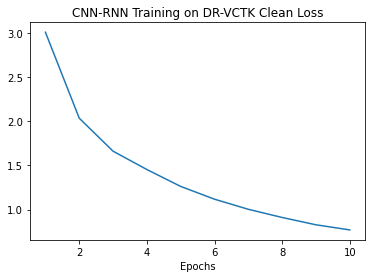

In [28]:
x = np.linspace(1, 10, 10)
plt.plot(x, clean_train_losses)
plt.xlabel('Epochs')
plt.title("CNN-RNN Training on DR-VCTK Clean Loss")
plt.show()

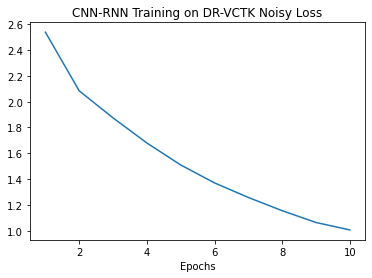

In [29]:
x = np.linspace(1, 10, 10)
plt.plot(x, noisy_train_losses)
plt.xlabel('Epochs')
plt.title("CNN-RNN Training on DR-VCTK Noisy Loss")
plt.show()

In [30]:
# Old attempt wasnt working well

In [31]:
# labels = [ "'",'|', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# print(len(labels))

In [32]:
# Encode trasncripts

# def label_to_index(word):
#     res = []
#     for i in range(len(word)):
#       res.append(labels.index(word[i]))
#     # Return the position of the word in labels
#     return res

# def index_to_label(index):
#     # Return the word corresponding to the index in labels
#     # This is the inverse of label_to_index
#     res = []
#     for i in index:
#       ch = labels[i]
#       res.append(ch)
#     return "".join(res)

In [33]:
# # Prepreoccessing the spectrograms for train and validation
# train_audio_transforms = torch.nn.Sequential(
#     torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
#     torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
#     torchaudio.transforms.TimeMasking(time_mask_param=35)
# )

# valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

In [34]:

# def processing(data, type_data="train", type_data2 = "clean"):

#     spectrograms = []
#     labels = []
#     input_lengths = []
#     label_lengths = []

#     for clean_waveform, _, noisy_waveform, _, speaker_id, utterance_id, _, _ in data:

#         if type_data == 'train':
#           if type_data2 == "clean":
#             spec = train_audio_transforms(clean_waveform).squeeze(0).transpose(0, 1)
#           else:
#             spec = train_audio_transforms(noisy_waveform).squeeze(0).transpose(0, 1)
#         else:
#             if type_data2 == "clean":
#               spec = valid_audio_transforms(clean_waveform).squeeze(0).transpose(0, 1)
#             else:
#               spec = valid_audio_transforms(noisy_waveform).squeeze(0).transpose(0, 1)


#         spectrograms.append(spec)
#         label = torch.Tensor(label_to_index(speaker_utterance_final[speaker_id][utterance_id]))
#         labels.append(label)
#         input_lengths.append(spec.shape[0]//2)
#         label_lengths.append(len(label))

#     spectrograms = torch.nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
#     labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)

#     return spectrograms, labels, input_lengths, label_lengths

In [35]:
# # Building the network
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

# class CNNLayerNorm(nn.Module):
#     # """Layer normalization built for cnns input"""
#     def __init__(self, n_feats):
#         super(CNNLayerNorm, self).__init__()
#         self.layer_norm = nn.LayerNorm(n_feats)

#     def forward(self, x):
#         # x (batch, channel, feature, time)
#         x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
#         x = self.layer_norm(x)
#         return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 

# class ResidualCNN(nn.Module):
#     # """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
#     #     except with layer norm instead of batch norm
#     # """
#     def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
#         super(ResidualCNN, self).__init__()

#         self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
#         self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
#         self.dropout1 = nn.Dropout(dropout)
#         self.dropout2 = nn.Dropout(dropout)
#         self.layer_norm1 = CNNLayerNorm(n_feats)
#         self.layer_norm2 = CNNLayerNorm(n_feats)

#     def forward(self, x):
#         residual = x  # (batch, channel, feature, time)
#         x = self.layer_norm1(x)
#         x = F.gelu(x)
#         x = self.dropout1(x)
#         x = self.cnn1(x)
#         x = self.layer_norm2(x)
#         x = F.gelu(x)
#         x = self.dropout2(x)
#         x = self.cnn2(x)
#         x += residual
#         return x # (batch, channel, feature, time)
        
# class BidirectionalGRU(nn.Module):

#     def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
#         super(BidirectionalGRU, self).__init__()

#         self.BiGRU = nn.GRU(
#             input_size=rnn_dim, hidden_size=hidden_size,
#             num_layers=1, batch_first=batch_first, bidirectional=True)
#         self.layer_norm = nn.LayerNorm(rnn_dim)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         x = self.layer_norm(x)
#         x = F.gelu(x)
#         x, _ = self.BiGRU(x)
#         x = self.dropout(x)
#         return x


# class SpeechRecognitionModel(nn.Module):
#     # """Speech Recognition Model Inspired by DeepSpeech 2"""

#     def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
#         super(SpeechRecognitionModel, self).__init__()
#         n_feats = n_feats//2
#         self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

#         # n residual cnn layers with filter size of 32
#         self.rescnn_layers = nn.Sequential(*[
#             ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
#             for _ in range(n_cnn_layers)
#         ])
#         self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
#         self.birnn_layers = nn.Sequential(*[
#             BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
#                              hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
#             for i in range(n_rnn_layers)
#         ])
#         self.classifier = nn.Sequential(
#             nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(rnn_dim, n_class)
#         )

#     def forward(self, x):
#         x = self.cnn(x)
#         x = self.rescnn_layers(x)
#         sizes = x.size()
#         x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
#         x = x.transpose(1, 2) # (batch, time, feature)
#         x = self.fully_connected(x)
#         x = self.birnn_layers(x)
#         x = self.classifier(x)
#         return x

In [36]:
# Set Hyperparameters
# n_epochs = 10 # max_epochs
# batch_size_train = 20 # batch size train set
# batch_size_test = 20 # batch size test set
# learning_rate = 5e-4 # learn rate
# log_interval = 1 # log every _ epoch


# n_cnn_layers = 3
# n_rnn_layers = 3
# rnn_dim = 512
# n_class = 29
# n_feats = 128
# stride = 2
# dropout = .1

In [37]:
# model = SpeechRecognitionModel(n_cnn_layers, n_rnn_layers, rnn_dim,n_class, n_feats, stride, dropout).to(device)
# print(model)
# print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

In [38]:
# def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
#     arg_maxes = torch.argmax(output, dim=2) # arg max n classes
#     decodes = []
#     targets = []
#     for i, args in enumerate(arg_maxes): # for sample in batch
#         decode = []
#         targets.append(index_to_label(labels[i][:label_lengths[i]].tolist()))
#         for j, index in enumerate(args): # for frame in sample
#             if index != blank_label:
#                 if collapse_repeated and j != 0 and index == args[j -1]:
#                     continue
#                 decode.append(index.item())
#         decodes.append(index_to_label(decode))
#     return decodes, targets

In [39]:
# !pip install jiwer
# from jiwer import wer
# from jiwer import cer

In [40]:
# import numpy as np

# # Results of Training
# losses = []
# test_losses = []
# wers_epoch = []
# cers_epoch = []


# Training_Result = (losses, test_losses, wers_epoch, cers_epoch)

In [41]:
# use_cuda = torch.cuda.is_available()
# kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
# clean_train_loader = torch.utils.data.DataLoader(dataset=drvctk_train_dataset,
#                             batch_size=batch_size_train,
#                             shuffle=True,
#                             collate_fn=lambda x: processing(x, 'train',"clean"))
# clean_test_loader = torch.utils.data.DataLoader(dataset=drvctk_test_dataset,
#                             batch_size=batch_size_test,
#                             shuffle=False,
#                             collate_fn=lambda x: processing(x, 'valid', "clean"))

In [42]:
# optimizer = optim.AdamW(model.parameters(), learning_rate)
# criterion = nn.CTCLoss(blank=28).to(device)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
#                                         steps_per_epoch=int(len(clean_train_loader)),
#                                         epochs=n_epochs,
#                                         anneal_strategy='linear')

In [43]:
# import copy

# # Train Function
# def train(Training_Result_p):

#   losses, test_losses, wers_epoch, cers_epoch = Training_Result_p

#   # Train parameters
#   epoch = 1 # starting epoch
 

#   print("Training model")

#   while ((epoch <= n_epochs) ):
    
#     # Training
#     model.train()
#     train_loss = 0 # calc train loss
#     for batch_idx, _data in enumerate(clean_train_loader):

#       spectrograms, labels, input_lengths, label_lengths = _data 

#       spectrograms, labels = spectrograms.to(device), labels.to(device)

#       optimizer.zero_grad()

#       output = model(spectrograms)  # (batch, time, n_class)
#       output = F.log_softmax(output, dim=2)
#       output = output.transpose(0, 1) # (time, batch, n_class)

#       loss = criterion(output, labels, input_lengths, label_lengths)
#       loss.backward()

#       train_loss += loss.item()

#       if batch_idx % 100 == 0:
#         print("Epoch: {} Batch: {}/ {}  Batch Loss: {}".format(epoch, batch_idx, len(clean_train_loader), loss.item()))

#       optimizer.step()
#       scheduler.step()
    
#     losses.append(train_loss / len(drvctk_train_dataset))

#     print('Epoch: {}, Train Average loss: {:.4f}\n'.format(epoch,train_loss / len(drvctk_train_dataset)))

#     # Evaluation 
#     model.eval()
#     test_loss = 0
#     test_cer, test_wer = [], []
#     with torch.no_grad():
#       for batch_idx, _data in enumerate(clean_test_loader):

#         spectrograms, labels, input_lengths, label_lengths = _data 

#         spectrograms, labels = spectrograms.to(device), labels.to(device)

#         output = model(spectrograms)  # (batch, time, n_class)
#         output = F.log_softmax(output, dim=2)
#         output = output.transpose(0, 1) # (time, batch, n_class)

#         loss = criterion(output, labels, input_lengths, label_lengths)
#         test_loss += loss.item() 

#         decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)

#         for j in range(len(decoded_preds)):
#             test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
#             test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


#     avg_cer = sum(test_cer)/len(test_cer)
#     avg_wer = sum(test_wer)/len(test_wer)

#     test_losses.append(test_loss/len(drvctk_test_dataset))
#     wers_epoch.append(avg_wer)
#     cers_epoch.append(avg_cer)

#     print('Epoch: {}, Test Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(epoch,test_loss/len(drvctk_test_dataset), avg_cer, avg_wer))

#     torch.save(model, '/content/drive/My Drive/DLS_Project/best_deep_s.pt')
    
#     # increment epoch
#     epoch += 1
  
#   print("Training Finished!")
#   Training_Return = (losses,test_losses, wers_epoch, cers_epoch)
#   return Training_Return

In [44]:
# # Train MNIST with test set as validation
# res = train(Training_Result)

# losses,test_losses, wers_epoch, cers_epoch = res

In [45]:
# model.eval()
# test_loss = 0
# test_cer, test_wer = [], []
# with torch.no_grad():
#   for _data in clean_test_loader:

#     spectrograms, labels, input_lengths, label_lengths = _data 

#     spectrograms, labels = spectrograms.to(device), labels.to(device)

#     output = model(spectrograms)  # (batch, time, n_class)
#     output = F.log_softmax(output, dim=2)
#     output = output.transpose(0, 1) # (time, batch, n_class)

#     loss = criterion(output, labels, input_lengths, label_lengths)
#     test_loss += loss.item() 

#     print(output.transpose(0, 1))
#     print(labels)
#     decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)

#     for j in range(len(decoded_preds)):
#         test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
#         test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


# avg_cer = sum(test_cer)/len(test_cer)
# avg_wer = sum(test_wer)/len(test_wer)

# test_losses.append(test_loss/len(drvctk_test_dataset))
# wers_epoch.append(avg_wer)
# cers_epoch.append(avg_cer)